# USING MINILM TO GENERATE EMBEDDINGS

In [ ]:
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
dataset_train = load_dataset("yelp_review_full", split="train[:50000]")
dataset_test = load_dataset("yelp_review_full", split="test[:5000]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset_test

Dataset({
    features: ['label', 'text'],
    num_rows: 5000
})

In [ ]:
def get_embeddings(sentences):
  model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
  embeddings = model.encode(sentences)
  return (embeddings)

train_embeddings = get_embeddings(dataset_train['text'])
test_embeddings = get_embeddings(dataset_test['text'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
train_embeddings

array([[ 0.04555464, -0.05268644,  0.04645709, ..., -0.06225803,
        -0.0360694 ,  0.00246232],
       [ 0.02939853, -0.01797771,  0.06661218, ..., -0.04091648,
        -0.04300738,  0.01182602],
       [ 0.0389641 , -0.03705919,  0.00892648, ..., -0.05102391,
         0.03820181,  0.00499409],
       ...,
       [-0.07744304, -0.03974559,  0.01488896, ..., -0.05781585,
        -0.0423006 , -0.04051163],
       [-0.08529283,  0.0889803 ,  0.13636836, ...,  0.02599588,
        -0.09955091,  0.10780361],
       [-0.10055664, -0.00578744,  0.04203502, ..., -0.0820699 ,
        -0.05699826, -0.01862569]], dtype=float32)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

train_embeddings_tensor = torch.tensor(train_embeddings)
test_embeddings_tensor = torch.tensor(test_embeddings)
train_label_tensor = torch.tensor(dataset_train['label'])
test_label_tensor = torch.tensor(dataset_test['label'])

combined_dataset_train = TensorDataset(train_embeddings_tensor, train_label_tensor)
combined_dataset_test = TensorDataset(test_embeddings_tensor, test_label_tensor)

save_dir = "/content/drive/MyDrive/CS521/"
# Store combined_dataset_train
torch.save(combined_dataset_train, save_dir + 'combined_dataset_train.pt')

# Store combined_dataset_test
torch.save(combined_dataset_test, save_dir + 'combined_dataset_test.pt')

# Load the embeddings and the created tensor and start model training....

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from google.colab import drive
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/CS521/"

combined_dataset_train = torch.load(save_dir + 'combined_dataset_train.pt')
combined_dataset_test = torch.load(save_dir + 'combined_dataset_test.pt')


train_loader = DataLoader(dataset=combined_dataset_train,
                          batch_size=64,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=combined_dataset_test,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Display the number of parameters and model structure
def display_model(model):
  # Check number of parameters
  summary_dict = {}
  num_params = 0
  summary_str = ['='*80]

  for module_name, module in model.named_children():
      summary_count = 0
      for name, param in module.named_parameters():
          if(param.requires_grad):
              summary_count += param.numel()
              num_params += param.numel()
      summary_dict[module_name] = [summary_count]
      summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

  summary_dict['total'] = [num_params]

  # print summary string
  summary_str += ['='*80]
  summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
  print('\n'.join(summary_str))

  # print model structure
  print(model)

# Plot loss or accuracy
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Accuracy Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_checkpoint(save_dir, model, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def load_model(model, save_dir, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path))
    return model

In [ ]:
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (features, labels) in it_train:
        #labels, input_ids, token_type_ids, attention_mask = data['label'], data['input_ids'], data['token_type_ids'], data['attention_mask']

        #labels, input_ids = labels.to(device), input_ids.to(device)

        # zero the gradient
        optimizer.zero_grad()

        # predict labels
        prediction = model(features)

        # compute loss
        loss = criterion(prediction, labels)

        # set text to display
        it_train.set_description(f'loss: {loss:.3f}')

        # compute gradients
        loss.backward()

        # update weights
        optimizer.step()

        # keep track of losses
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (features, labels) in it_test:

      #labels, input_ids, token_type_ids, attention_mask = data['label'], data['input_ids'], data['token_type_ids'], data['attention_mask']

      #labels, input_ids = labels.to(device), input_ids.to(device)

      with torch.no_grad():  # https://pytorch.org/docs/stable/generated/torch.no_grad.html
       output = model(features) # do not compute gradient when performing prediction
      preds = torch.argmax(output, dim=-1)
      loss = criterion(output, labels)
      losses.append(loss.item())
      correct += (preds == labels).sum().item()
      total += len(labels)

    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))

    return mean_accuracy, test_loss

In [ ]:
# Create a mini Model
from torch import nn
class modelY(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(modelY, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),

            nn.Linear(100, output_size),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
input_size, output_size = 384, 5
model_y = modelY(input_size, output_size)
display_model(model_y) # displays the model structure and parameter count

- linear_relu_stack                        :               49105               
--Total                                    :            49105 params           --
modelY(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=384, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=5, bias=True)
    (5): Softmax(dim=None)
  )
)



Training ...:   0%|          | 0/15 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training ...:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
loss: 1.205: 100%|██████████| 782/782 [00:05<00:00, 139.47it/s]


Loss for Training on epoch 0 is 1.4174288511276245 

Evaluating Network


Validating ...: 100%|██████████| 782/782 [00:01<00:00, 440.59it/s]

Mean Accuracy: 0.5195
Avg loss: 1.3717347849970278
Training accuracy on epoch 0 is 0.51946 




Validating ...: 100%|██████████| 79/79 [00:00<00:00, 391.82it/s]

Training ...:   7%|▋         | 1/15 [00:08<01:53,  8.12s/it]

Mean Accuracy: 0.5026
Avg loss: 1.3853204899196383
Test (val) accuracy on epoch 0 is 0.5026 

Saving Model


loss: 1.269: 100%|██████████| 782/782 [00:06<00:00, 126.82it/s]


Loss for Training on epoch 1 is 1.371814489364624 

Evaluating Network


Validating ...: 100%|██████████| 782/782 [00:01<00:00, 457.17it/s]

Mean Accuracy: 0.5183
Avg loss: 1.3701644103850246
Training accuracy on epoch 1 is 0.51834 




Validating ...: 100%|██████████| 79/79 [00:00<00:00, 365.45it/s]

Training ...:  13%|█▎        | 2/15 [00:16<01:46,  8.21s/it]

Mean Accuracy: 0.4972
Avg loss: 1.3878992101814174
Test (val) accuracy on epoch 1 is 0.4972 



loss: 1.217: 100%|██████████| 782/782 [00:05<00:00, 138.86it/s]

Training ...:  20%|██        | 3/15 [00:22<01:24,  7.06s/it]

Loss for Training on epoch 2 is 1.3628894090652466 



loss: 1.323: 100%|██████████| 782/782 [00:05<00:00, 131.71it/s]

Training ...:  27%|██▋       | 4/15 [00:28<01:13,  6.65s/it]

Loss for Training on epoch 3 is 1.3580039739608765 



loss: 1.461: 100%|██████████| 782/782 [00:05<00:00, 137.18it/s]

Training ...:  33%|███▎      | 5/15 [00:33<01:03,  6.33s/it]

Loss for Training on epoch 4 is 1.354248046875 



loss: 1.480: 100%|██████████| 782/782 [00:05<00:00, 133.54it/s]


Loss for Training on epoch 5 is 1.3428115844726562 

Evaluating Network


Validating ...: 100%|██████████| 782/782 [00:01<00:00, 437.02it/s]

Mean Accuracy: 0.5567
Avg loss: 1.3406642484847846
Training accuracy on epoch 5 is 0.55666 




Validating ...: 100%|██████████| 79/79 [00:00<00:00, 393.18it/s]

Training ...:  40%|████      | 6/15 [00:41<01:02,  6.92s/it]

Mean Accuracy: 0.5192
Avg loss: 1.3707548651514174
Test (val) accuracy on epoch 5 is 0.5192 

Saving Model


loss: 1.231: 100%|██████████| 782/782 [00:05<00:00, 132.80it/s]

Training ...:  47%|████▋     | 7/15 [00:47<00:52,  6.61s/it]

Loss for Training on epoch 6 is 1.34114670753479 



loss: 1.205: 100%|██████████| 782/782 [00:06<00:00, 129.27it/s]

Training ...:  53%|█████▎    | 8/15 [00:54<00:45,  6.46s/it]

Loss for Training on epoch 7 is 1.3402109146118164 



loss: 1.321: 100%|██████████| 782/782 [00:05<00:00, 136.67it/s]

Training ...:  60%|██████    | 9/15 [00:59<00:37,  6.26s/it]

Loss for Training on epoch 8 is 1.3394484519958496 



loss: 1.317: 100%|██████████| 782/782 [00:05<00:00, 131.49it/s]

Training ...:  67%|██████▋   | 10/15 [01:05<00:30,  6.18s/it]

Loss for Training on epoch 9 is 1.3389086723327637 



loss: 1.290: 100%|██████████| 782/782 [00:05<00:00, 136.62it/s]


Loss for Training on epoch 10 is 1.3373018503189087 

Evaluating Network


Validating ...: 100%|██████████| 782/782 [00:01<00:00, 443.61it/s]


Mean Accuracy: 0.5626
Avg loss: 1.3372061403511126
Training accuracy on epoch 10 is 0.56264 



Validating ...: 100%|██████████| 79/79 [00:00<00:00, 360.23it/s]

Training ...:  73%|███████▎  | 11/15 [01:13<00:26,  6.71s/it]

Mean Accuracy: 0.5212
Avg loss: 1.3706189348727842
Test (val) accuracy on epoch 10 is 0.5212 

Saving Model


loss: 1.440: 100%|██████████| 782/782 [00:05<00:00, 132.09it/s]

Training ...:  80%|████████  | 12/15 [01:19<00:19,  6.50s/it]

Loss for Training on epoch 11 is 1.3372834920883179 



loss: 1.231: 100%|██████████| 782/782 [00:05<00:00, 139.41it/s]

Training ...:  87%|████████▋ | 13/15 [01:25<00:12,  6.25s/it]

Loss for Training on epoch 12 is 1.3369991779327393 



loss: 1.246: 100%|██████████| 782/782 [00:06<00:00, 130.06it/s]

Training ...:  93%|█████████▎| 14/15 [01:31<00:06,  6.20s/it]

Loss for Training on epoch 13 is 1.3369402885437012 



loss: 1.319: 100%|██████████| 782/782 [00:05<00:00, 139.59it/s]


Loss for Training on epoch 14 is 1.33695650100708 

Evaluating Network


Validating ...: 100%|██████████| 782/782 [00:01<00:00, 444.97it/s]

Mean Accuracy: 0.5631
Avg loss: 1.3366581343323982
Training accuracy on epoch 14 is 0.56314 




Validating ...: 100%|██████████| 79/79 [00:00<00:00, 378.28it/s]

Training ...: 100%|██████████| 15/15 [01:39<00:00,  6.62s/it]


Mean Accuracy: 0.5214
Avg loss: 1.3706099187271505
Test (val) accuracy on epoch 14 is 0.5214 

Saving Model


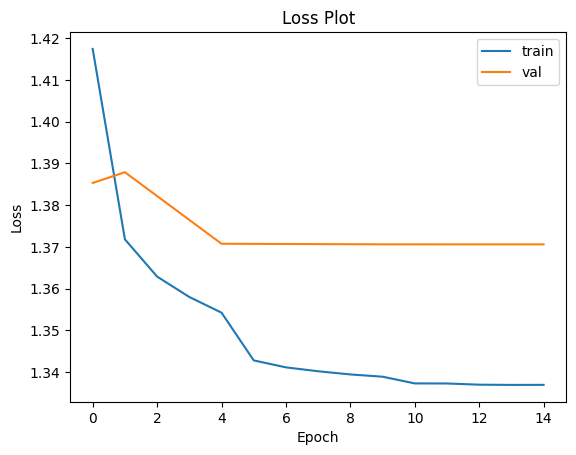

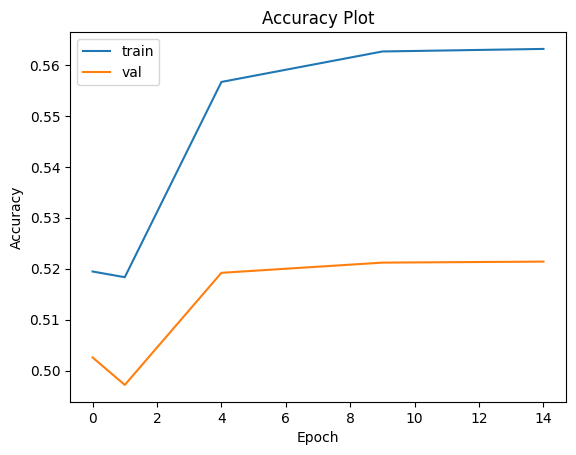

In [ ]:
# Training Setting. Feel free to change.
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
def train_wrapper(model, num_epochs, test_interval, learn_rate, is_student = False):
  path = 'best_model_s.pth' if is_student else 'best_model.pth'

  optimizer = torch.optim.Adam(model_y.parameters(), lr=learn_rate)

  lr_scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  criterion = torch.nn.CrossEntropyLoss()

  train_losses = []
  train_accuracy_list = []
  test_losses = []
  test_accuracy_list = []


  # Iterate over the DataLoader for training data
  for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):

      # Train the network for one epoch
      train_loss = train(train_loader, model_y, criterion, optimizer)

      # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
      lr_scheduler.step()

      train_losses.append(train_loss)
      print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

      # Get the train accuracy and test loss/accuracy
      if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
          print('Evaluating Network')

          train_accuracy, _ = test(train_loader, model_y, criterion) # Get training accuracy
          train_accuracy_list.append(train_accuracy)

          print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

          test_accuracy, test_loss = test(test_loader, model_y, criterion) # Get testing accuracy and error
          test_losses.append(test_loss)
          test_accuracy_list.append(test_accuracy)
          print(f'Test (val) accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')

          # Checkpoints are used to save the model with best validation accuracy
          if test_accuracy >= max(test_accuracy_list):
            print("Saving Model")
            save_checkpoint(save_dir, model_y, save_name = path) # Save model with best performance
  plot_losses(train_losses, test_losses, test_interval, num_epochs)
  plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)

train_wrapper(model_y, 15, 5, pow(10, -3), False)

In [ ]:
model_y = load_model(model_y, save_dir, 'best_model.pth') # Load the trained weight

test_accuracy, test_loss= test(test_loader, model_y, torch.nn.CrossEntropyLoss())
print(f"Validation accuracy is {str(test_accuracy)} \n")

Validating ...: 100%|██████████| 79/79 [00:00<00:00, 340.77it/s]

Mean Accuracy: 0.5214
Avg loss: 1.3706099187271505
Validation accuracy is 0.5214 



## Create a student Model

In [ ]:
# Create a mini Model
from torch import nn
class modelS(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(modelS, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 5),
            nn.ReLU(),

            nn.Linear(5, output_size),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
input_size, output_size = 384, 5
model_s = modelS(input_size, output_size)
display_model(model_s) # displays the model structure and parameter count

- linear_relu_stack                        :                1955               
--Total                                    :            1955 params            --
modelS(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=384, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): Softmax(dim=None)
  )
)



loss: 1.282: 100%|██████████| 782/782 [00:05<00:00, 135.80it/s]


Loss for Training on epoch 0 is 1.3459594249725342 

Evaluating Network


Validating ...: 100%|██████████| 782/782 [00:01<00:00, 408.32it/s]

Mean Accuracy: 0.5600
Avg loss: 1.3383061681562067
Training accuracy on epoch 0 is 0.55998 




Validating ...: 100%|██████████| 79/79 [00:00<00:00, 398.04it/s]


Mean Accuracy: 0.5108
Avg loss: 1.3752930496312394
Test (val) accuracy on epoch 0 is 0.5108 

Saving Model



loss: 1.397: 100%|██████████| 782/782 [00:05<00:00, 138.83it/s]


Loss for Training on epoch 1 is 1.3426575660705566 

Evaluating Network


Validating ...: 100%|██████████| 782/782 [00:02<00:00, 300.15it/s]

Mean Accuracy: 0.5606
Avg loss: 1.3362639224742685
Training accuracy on epoch 1 is 0.56064 




Validating ...: 100%|██████████| 79/79 [00:00<00:00, 299.30it/s]

Training ...:  13%|█▎        | 2/15 [00:17<01:51,  8.58s/it]

Mean Accuracy: 0.5154
Avg loss: 1.3725428701956062
Test (val) accuracy on epoch 1 is 0.5154 

Saving Model


loss: 1.456: 100%|██████████| 782/782 [00:06<00:00, 128.88it/s]

Training ...:  20%|██        | 3/15 [00:23<01:29,  7.48s/it]

Loss for Training on epoch 2 is 1.3392571210861206 



loss: 1.374: 100%|██████████| 782/782 [00:05<00:00, 134.91it/s]

Training ...:  27%|██▋       | 4/15 [00:29<01:15,  6.85s/it]

Loss for Training on epoch 3 is 1.3347456455230713 



loss: 1.311: 100%|██████████| 782/782 [00:05<00:00, 134.92it/s]

Training ...:  33%|███▎      | 5/15 [00:35<01:05,  6.51s/it]

Loss for Training on epoch 4 is 1.330452799797058 



loss: 1.299: 100%|██████████| 782/782 [00:05<00:00, 139.70it/s]


Loss for Training on epoch 5 is 1.3165454864501953 

Evaluating Network


Validating ...: 100%|██████████| 782/782 [00:01<00:00, 429.11it/s]

Mean Accuracy: 0.5897
Avg loss: 1.3138666419726808
Training accuracy on epoch 5 is 0.58974 




Validating ...: 100%|██████████| 79/79 [00:00<00:00, 338.07it/s]

Training ...:  40%|████      | 6/15 [00:42<01:02,  6.97s/it]

Mean Accuracy: 0.5202
Avg loss: 1.3701408784600753
Test (val) accuracy on epoch 5 is 0.5202 

Saving Model


loss: 1.330: 100%|██████████| 782/782 [00:05<00:00, 136.60it/s]

Training ...:  47%|████▋     | 7/15 [00:48<00:52,  6.59s/it]

Loss for Training on epoch 6 is 1.3142114877700806 



loss: 1.100: 100%|██████████| 782/782 [00:05<00:00, 133.71it/s]

Training ...:  53%|█████▎    | 8/15 [00:54<00:44,  6.38s/it]

Loss for Training on epoch 7 is 1.3125383853912354 



loss: 1.320: 100%|██████████| 782/782 [00:05<00:00, 137.98it/s]

Training ...:  60%|██████    | 9/15 [01:00<00:37,  6.18s/it]

Loss for Training on epoch 8 is 1.311572790145874 



loss: 1.371: 100%|██████████| 782/782 [00:05<00:00, 139.80it/s]

Training ...:  67%|██████▋   | 10/15 [01:06<00:30,  6.03s/it]

Loss for Training on epoch 9 is 1.3105021715164185 



loss: 1.187: 100%|██████████| 782/782 [00:05<00:00, 136.62it/s]


Loss for Training on epoch 10 is 1.3084688186645508 

Evaluating Network


Validating ...: 100%|██████████| 782/782 [00:01<00:00, 449.14it/s]

Mean Accuracy: 0.5982
Avg loss: 1.3078885680574286
Training accuracy on epoch 10 is 0.59818 




Validating ...: 100%|██████████| 79/79 [00:00<00:00, 382.29it/s]

Training ...:  73%|███████▎  | 11/15 [01:13<00:26,  6.60s/it]

Mean Accuracy: 0.5232
Avg loss: 1.3693741107288795
Test (val) accuracy on epoch 10 is 0.5232 

Saving Model


loss: 1.375: 100%|██████████| 782/782 [00:05<00:00, 139.89it/s]

Training ...:  80%|████████  | 12/15 [01:19<00:18,  6.32s/it]

Loss for Training on epoch 11 is 1.3083512783050537 



loss: 1.269: 100%|██████████| 782/782 [00:05<00:00, 135.31it/s]

Training ...:  87%|████████▋ | 13/15 [01:25<00:12,  6.18s/it]

Loss for Training on epoch 12 is 1.3081409931182861 



loss: 1.443: 100%|██████████| 782/782 [00:05<00:00, 137.11it/s]

Training ...:  93%|█████████▎| 14/15 [01:31<00:06,  6.07s/it]

Loss for Training on epoch 13 is 1.3081823587417603 



loss: 1.092: 100%|██████████| 782/782 [00:05<00:00, 132.94it/s]


Loss for Training on epoch 14 is 1.3077421188354492 

Evaluating Network


Validating ...: 100%|██████████| 782/782 [00:01<00:00, 448.87it/s]

Mean Accuracy: 0.5990
Avg loss: 1.3076462731946765
Training accuracy on epoch 14 is 0.59904 




Validating ...: 100%|██████████| 79/79 [00:00<00:00, 385.80it/s]

Training ...: 100%|██████████| 15/15 [01:39<00:00,  6.63s/it]


Mean Accuracy: 0.5234
Avg loss: 1.3692474033259139
Test (val) accuracy on epoch 14 is 0.5234 

Saving Model


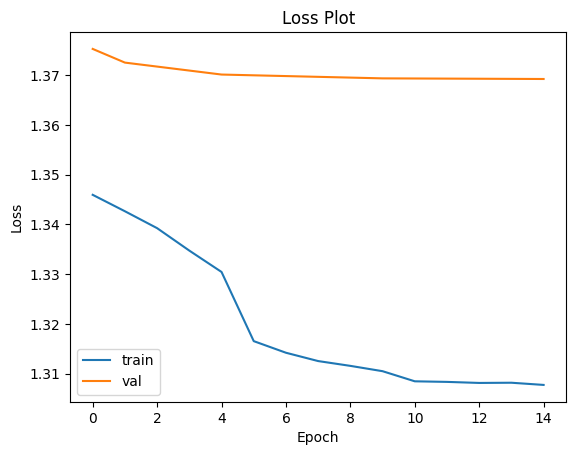

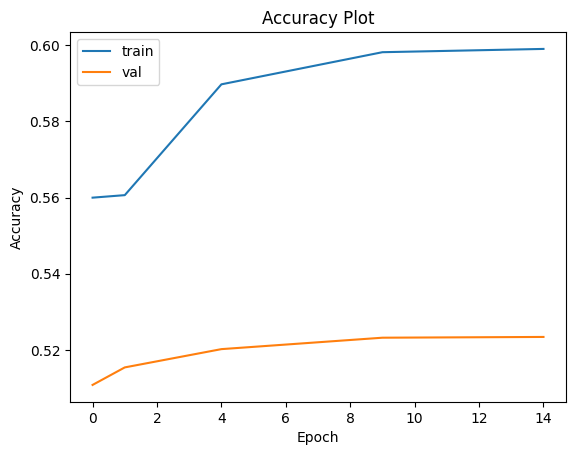

In [ ]:
train_wrapper(model_s, 15, 5, pow(10, -3), is_student = True)

In [ ]:
model_s = load_model(model_s, save_dir, 'best_model_s.pth') # Load the trained weight

test_accuracy, test_loss= test(test_loader, model_s, torch.nn.CrossEntropyLoss())
print(f"Validation accuracy is {str(test_accuracy)} \n")

RuntimeError: Error(s) in loading state_dict for modelS:
	Unexpected key(s) in state_dict: "linear_relu_stack.4.weight", "linear_relu_stack.4.bias". 
	size mismatch for linear_relu_stack.0.weight: copying a param with shape torch.Size([100, 384]) from checkpoint, the shape in current model is torch.Size([5, 384]).
	size mismatch for linear_relu_stack.0.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([5]).
	size mismatch for linear_relu_stack.2.weight: copying a param with shape torch.Size([100, 100]) from checkpoint, the shape in current model is torch.Size([5, 5]).
	size mismatch for linear_relu_stack.2.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([5]).

# Load the model Weights of Parent and start the distillation process

In [ ]:
from torch import nn
import torch
class Parent(torch.nn.Module):
    def __init__(self,input_size, output_size ):
        super(Parent, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),

            nn.Linear(100, output_size),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

input_size, output_size = 384, 5
parent_model = Parent(input_size, output_size)
PATH = '/content/drive/MyDrive/CS521/best_model.pth'
parent_model.load_state_dict(torch.load(PATH))
print('######################################')
parent_model.eval()

######################################


Parent(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=384, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=5, bias=True)
    (5): Softmax(dim=None)
  )
)

In [ ]:
from torch import nn
class Student(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Student, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 5),
            nn.ReLU(),

            nn.Linear(5, output_size),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

input_size, output_size = 384, 5
student_model = Student(input_size, output_size)
display_model(student_model)

- linear_relu_stack                        :                1955               
--Total                                    :            1955 params            --
Student(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=384, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): Softmax(dim=None)
  )
)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating ...:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Validating ...: 100%|██████████| 79/79 [00:00<00:00, 210.18it/s]

Mean Accuracy: 0.1972
Avg loss: 1.613145817684222



Validating ...: 100%|██████████| 782/782 [00:02<00:00, 329.71it/s]

Mean Accuracy: 0.1960
Avg loss: 1.6126465840107949


Epoch 1/15, Loss: 1.150944228519869


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 162.02it/s]

Mean Accuracy: 0.4568
Avg loss: 1.44510834881022



Validating ...: 100%|██████████| 782/782 [00:03<00:00, 218.59it/s]

Mean Accuracy: 0.4707
Avg loss: 1.4420300687060637


Epoch 2/15, Loss: 1.0740097579748735


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 271.11it/s]

Mean Accuracy: 0.4816
Avg loss: 1.413643090030815



Validating ...: 100%|██████████| 782/782 [00:02<00:00, 300.44it/s]

Mean Accuracy: 0.4965
Avg loss: 1.4081297120474794


Epoch 3/15, Loss: 1.0562199524144078


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 152.27it/s]

Mean Accuracy: 0.4914
Avg loss: 1.4005004952225504



Validating ...: 100%|██████████| 782/782 [00:02<00:00, 323.10it/s]

Mean Accuracy: 0.5073
Avg loss: 1.393861627639712


Epoch 4/15, Loss: 1.0472030659465839


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 280.74it/s]

Mean Accuracy: 0.4976
Avg loss: 1.3932353288312502



Validating ...: 100%|██████████| 782/782 [00:03<00:00, 251.40it/s]

Mean Accuracy: 0.5148
Avg loss: 1.3852588142580389


Epoch 5/15, Loss: 1.0411684992520704


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 168.91it/s]

Mean Accuracy: 0.5006
Avg loss: 1.3887297216849992



Validating ...: 100%|██████████| 782/782 [00:04<00:00, 186.40it/s]

Mean Accuracy: 0.5200
Avg loss: 1.3797508016266786


Epoch 6/15, Loss: 1.036692281132159


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 294.21it/s]

Mean Accuracy: 0.5076
Avg loss: 1.3853849610195885



Validating ...: 100%|██████████| 782/782 [00:02<00:00, 287.21it/s]

Mean Accuracy: 0.5239
Avg loss: 1.3749787176356596


Epoch 7/15, Loss: 1.0331361152784293


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 276.26it/s]

Mean Accuracy: 0.5100
Avg loss: 1.3827424396442463



Validating ...: 100%|██████████| 782/782 [00:03<00:00, 221.95it/s]

Mean Accuracy: 0.5286
Avg loss: 1.3710226428783154


Epoch 8/15, Loss: 1.0303018243264055


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 281.78it/s]

Mean Accuracy: 0.5096
Avg loss: 1.3812864234175863



Validating ...: 100%|██████████| 782/782 [00:02<00:00, 297.23it/s]

Mean Accuracy: 0.5302
Avg loss: 1.3682190324644299


Epoch 9/15, Loss: 1.0279694512829451


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 293.18it/s]

Mean Accuracy: 0.5144
Avg loss: 1.3789304962641076



Validating ...: 100%|██████████| 782/782 [00:04<00:00, 177.93it/s]

Mean Accuracy: 0.5333
Avg loss: 1.365552660296945


Epoch 10/15, Loss: 1.0261157722881689


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 149.64it/s]

Mean Accuracy: 0.5142
Avg loss: 1.3779311874244786



Validating ...: 100%|██████████| 782/782 [00:06<00:00, 124.43it/s]

Mean Accuracy: 0.5347
Avg loss: 1.3633346100292547


Epoch 11/15, Loss: 1.0244854130708347


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 289.28it/s]

Mean Accuracy: 0.5134
Avg loss: 1.3770162033129343



Validating ...: 100%|██████████| 782/782 [00:03<00:00, 249.27it/s]

Mean Accuracy: 0.5376
Avg loss: 1.3615863408578937


Epoch 12/15, Loss: 1.022953477585712


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 223.27it/s]

Mean Accuracy: 0.5112
Avg loss: 1.3770145358918588



Validating ...: 100%|██████████| 782/782 [00:02<00:00, 264.17it/s]

Mean Accuracy: 0.5373
Avg loss: 1.3602273627315336


Epoch 13/15, Loss: 1.0217587201644087


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 249.74it/s]

Mean Accuracy: 0.5176
Avg loss: 1.375683432892908



Validating ...: 100%|██████████| 782/782 [00:04<00:00, 182.45it/s]

Mean Accuracy: 0.5406
Avg loss: 1.358767191010058


Epoch 14/15, Loss: 1.0205447165405048


Validating ...: 100%|██████████| 79/79 [00:00<00:00, 246.03it/s]

Mean Accuracy: 0.5164
Avg loss: 1.37541223175918



Validating ...: 100%|██████████| 782/782 [00:02<00:00, 302.45it/s]

Mean Accuracy: 0.5416
Avg loss: 1.3573835080541918


Epoch 15/15, Loss: 1.0195550557292636


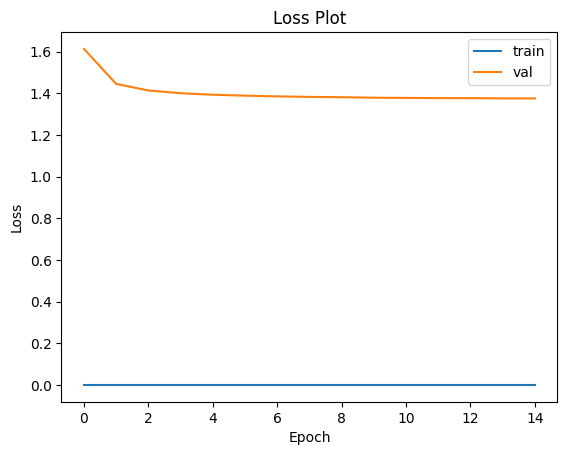

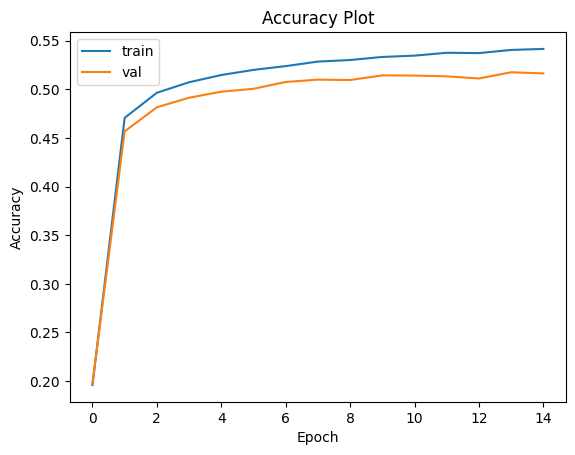

In [ ]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = [], [], [], []

    ce_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        train_loss_list.append(running_loss) # train loss
        test_result = test(test_loader, student, ce_loss)
        test_accuracy_list.append(test_result[0])  # append test accuracy
        test_loss_list.append(test_result[1])  # append test loss
        train_accuracy_list.append(test(train_loader, student, ce_loss)[0])  # Append train accuracy

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true laon form.bel loss
            label_loss = ce_loss(student_logits, labels)
train_knowledge_distillation(teacher=parent_model, student=student_model, train_loader=train_loader, epochs=15, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device='cpu')
            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

    plot_losses(train_loss_list, test_loss_list, 1, epochs)
    plot_accuracy(train_accuracy_list, test_accuracy_list, 1, epochs)

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=parent_model, student=student_model, train_loader=train_loader, epochs=15, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device='cpu')

In [ ]:
torch.save(student_model.state_dict(), '/content/drive/MyDrive/CS521/best_model_s.pth')

In [ ]:

test_accuracy, test_loss= test(test_loader, student_model, nn.CrossEntropyLoss())
print(f"Validation accuracy is {str(test_accuracy)} \n")

Validating ...: 100%|██████████| 79/79 [00:00<00:00, 283.67it/s]

Mean Accuracy: 0.5156
Avg loss: 1.3764417714710477
Validation accuracy is 0.5156 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Student(
  (quant): Quantize(scale=tensor([0.0021]), zero_point=tensor([117]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (linear_relu_stack): Sequential(
    (0): QuantizedLinearReLU(in_features=384, out_features=5, scale=0.026585714891552925, zero_point=0, qscheme=torch.per_tensor_affine)
    (1): Identity()
    (2): QuantizedLinear(in_features=5, out_features=5, scale=0.1576484590768814, zero_point=146, qscheme=torch.per_tensor_affine)
  )
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QuantizedLinearReLU(nn.Linear):
    def __init__(self, in_features, out_features, scale, zero_point, qscheme=torch.per_tensor_affine):
        super(QuantizedLinearReLU, self).__init__(in_features, out_features)
        self.scale = scale
        self.zero_point = zero_point
        self.qscheme = qscheme

    def forward(self, input):
        weight_q = torch.quantize_per_tensor(self.weight.float(), self.scale, self.zero_point, self.qscheme)
        bias_q = torch.quantize_per_tensor(self.bias.float(), self.scale, self.zero_point, self.qscheme)
        input_q = torch.quantize_per_tensor(input.float(), self.scale, self.zero_point, self.qscheme)
        output_q = F.linear(input_q.dequantize(), weight_q.dequantize(), bias_q.dequantize()).quantize(self.scale, self.zero_point, self.qscheme)
        return F.relu(output_q)

class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()

        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        self.linear_relu_stack = nn.Sequential(
            QuantizedLinearReLU(in_features=384, out_features=5, scale=0.026585714891552925, zero_point=0, qscheme=torch.per_tensor_affine),
            nn.Identity(),
        )

        self.quantized_linear = torch.nn.quantized.functional.linear

    def forward(self, x):
        x = self.quant(x)
        x = self.linear_relu_stack(x)
        x = self.quantized_linear(x, torch._empty_affine_quantized((5, 5), scale=0.1576484590768814, zero_point=146, dtype=torch.quint8))
        x = self.dequant(x)
        return x



model = Student()
model.load_state_dict(torch.load('/content/drive/MyDrive/CS521/quantized_model.pth'))
display_model(model)

RuntimeError: Error(s) in loading state_dict for Student:
	Missing key(s) in state_dict: "linear_relu_stack.0.weight", "linear_relu_stack.0.bias". 
	Unexpected key(s) in state_dict: "quant.scale", "quant.zero_point", "linear_relu_stack.2.scale", "linear_relu_stack.2.zero_point", "linear_relu_stack.2._packed_params.dtype", "linear_relu_stack.2._packed_params._packed_params", "linear_relu_stack.0.scale", "linear_relu_stack.0.zero_point", "linear_relu_stack.0._packed_params.dtype", "linear_relu_stack.0._packed_params._packed_params". 

In [ ]:
import torch
import torch.nn as nn

# Save the entire model (architecture and weights)
torch.save(parent_model, '/content/drive/MyDrive/CS521/test_model.pth')

# Load the entire model
model = torch.load('/content/drive/MyDrive/CS521/test_model.pth')

# Evaluation mode if necessary
model.eval()

Parent(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=384, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=5, bias=True)
    (5): Softmax(dim=None)
  )
)

In [ ]:
import torch
import torch.nn as nn

model = torch.load('/content/drive/MyDrive/CS521/test_model.pth')


AttributeError: Can't get attribute 'Parent' on <module '__main__'>

In [ ]:
for param in model.parameters():
  print(param.data)

NameError: name 'model' is not defined